# Imports

In [53]:
%cd /workspaces/Strategy/

# Basic utils
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
import sys

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee','no-latex'])

# Methods from de Prado
from Research.CODE.deprado import *

/workspaces/Strategy


# Set Plotting Variable

In [54]:
plotting = False

# Read in Vector for Labeling

In [55]:
# read in the steepness data
swap2s20s = pd.read_parquet('Research/CODE/tempData/swap2s20s.parquet')

# get y data and convert to decimal
y_data = swap2s20s['MID_PRICE'].copy() / 100

In [56]:
# Plot Steepness
if plotting:
    plt.figure()
    plt.plot(y_data * 10000)
    plt.xlabel('Date')
    plt.ylabel('Steepness [bps]')
    plt.savefig('Research/PLOTS/2s20s_steepness.png', format='png', dpi=300)
    plt.show()

# Read in the Feature Space

In [57]:
# Choose Features Version
version = 'V7'

# read in feature space X
X = pd.read_parquet(f'Research/CODE/tempData/features_{version}.parquet')

In [58]:
# dropping y data to match X
print(X.shape, y_data.shape)
mask = y_data.index.intersection(X.index)
y_data = y_data.loc[mask]
X = X.loc[mask]
print(X.shape, y_data.shape)

(9030, 10) (9042,)
(9030, 10) (9030,)


# Labeling

- input = y_data
- result = y

In [59]:
# fix target in bps
trgtval = 0.005
trgt = pd.Series(data=np.full(y_data.shape[0], trgtval), index=y_data.index)

In [60]:
# t1 = vertBar(y_data, y_data.index, 10) # 100 days limit
e = getEvents(y_data, trgt.index, ptSl=[1,1], trgt=trgt, minRet=0.00, numThreads=16, t1=False)
bins = getBins(e, y_data, trgtval)

2023-10-30 08:22:21.435295 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes..


In [61]:
y = bins['bin'].dropna()
e = e.drop(e[e['t1'].isnull()].index)
t1 = e['t1'].drop(e[e['t1'].isnull()].index)

In [62]:
print(X.shape, y.shape)
mask = y.index.intersection(X.index)
y = y.loc[mask]
X = X.loc[mask]
print(X.shape, y.shape)

(9030, 10) (8835,)
(8835, 10) (8835,)


In [63]:
print(X.index[0])
print(X.index[-1])

1999-01-10 00:00:00
2023-07-04 00:00:00


In [64]:
# Barrier Labeling Example

if plotting:
    y_copy = y_data.copy() * 10000
    date = '2009-05-07'
    event = e['t1'].loc[date]
    upper = y_copy.loc[date] + trgtval * 10000
    lower = y_copy.loc[date] - trgtval * 10000

    # Plot
    plt.figure()

    # Plot your data
    plt.plot(y_copy)

    plt.hlines(upper, pd.Timestamp(date), y_copy.index[-1], ls=':', color='r')
    plt.hlines(lower, pd.Timestamp(date), y_copy.index[-1], ls=':', color='r')
    plt.hlines(y_copy.loc[date], pd.Timestamp(date), y_copy.index[-1], ls=':', color='r')
    plt.vlines(pd.Timestamp(date), upper, lower, color='r')
    plt.annotate("Lower barrier is hit first", xy=(pd.Timestamp(event), y_copy.loc[event]), xytext=(pd.Timestamp(event), lower - 200), arrowprops=dict(arrowstyle="->",color='r'), color='r')
    plt.ylabel('Steepness [bps]')
    plt.xlabel('Date')
    
    # Save the plot if not already saved
    file_path = f"Research/PLOTS/barrier_labeling.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')

    plt.show()


In [65]:
# Plot the derived labels

if plotting:
    y_copy = y_data.copy() * 10000
    plt.figure()
    plt.plot(y_copy)
    plt.scatter(bins['bin'].index[bins['bin'] == -1], y_copy.loc[bins.index].loc[bins['bin'] == -1], c='red', s=5)
    plt.scatter(bins['bin'].index[bins['bin'] == 1], y_copy.loc[bins.index].loc[bins['bin'] == 1], c='green', s=5)
    # plt.scatter(bins['bin'].index[bins['bin'] == 0], y_copy.loc[bins.index].loc[bins['bin'] == 0], c='blue', s=5)
    plt.legend(['Steepness', 'Label "-1"', 'Label "1"'])
    # plt.title(f'Labeling with {int(trgtval * 10000)} bps Barrier')
    plt.xlabel('Date')
    plt.ylabel('Steepness [bps]')

    # Save the plot if not already saved
    file_path = f"Research/PLOTS/derived_labels.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')

    plt.show()


In [66]:
plotting = True

# Correlation Matrix

File already exists
Cluster : Features
0 : ['CPI', 'PPI', 'GDP', 'M1 Money Supply', 'M2 Money Supply', 'M3 Money Supply']
1 : ['Unemployment Rate', 'ECB Refinancing Rate', 'M1 Money Velocity', 'M2 Money Velocity']


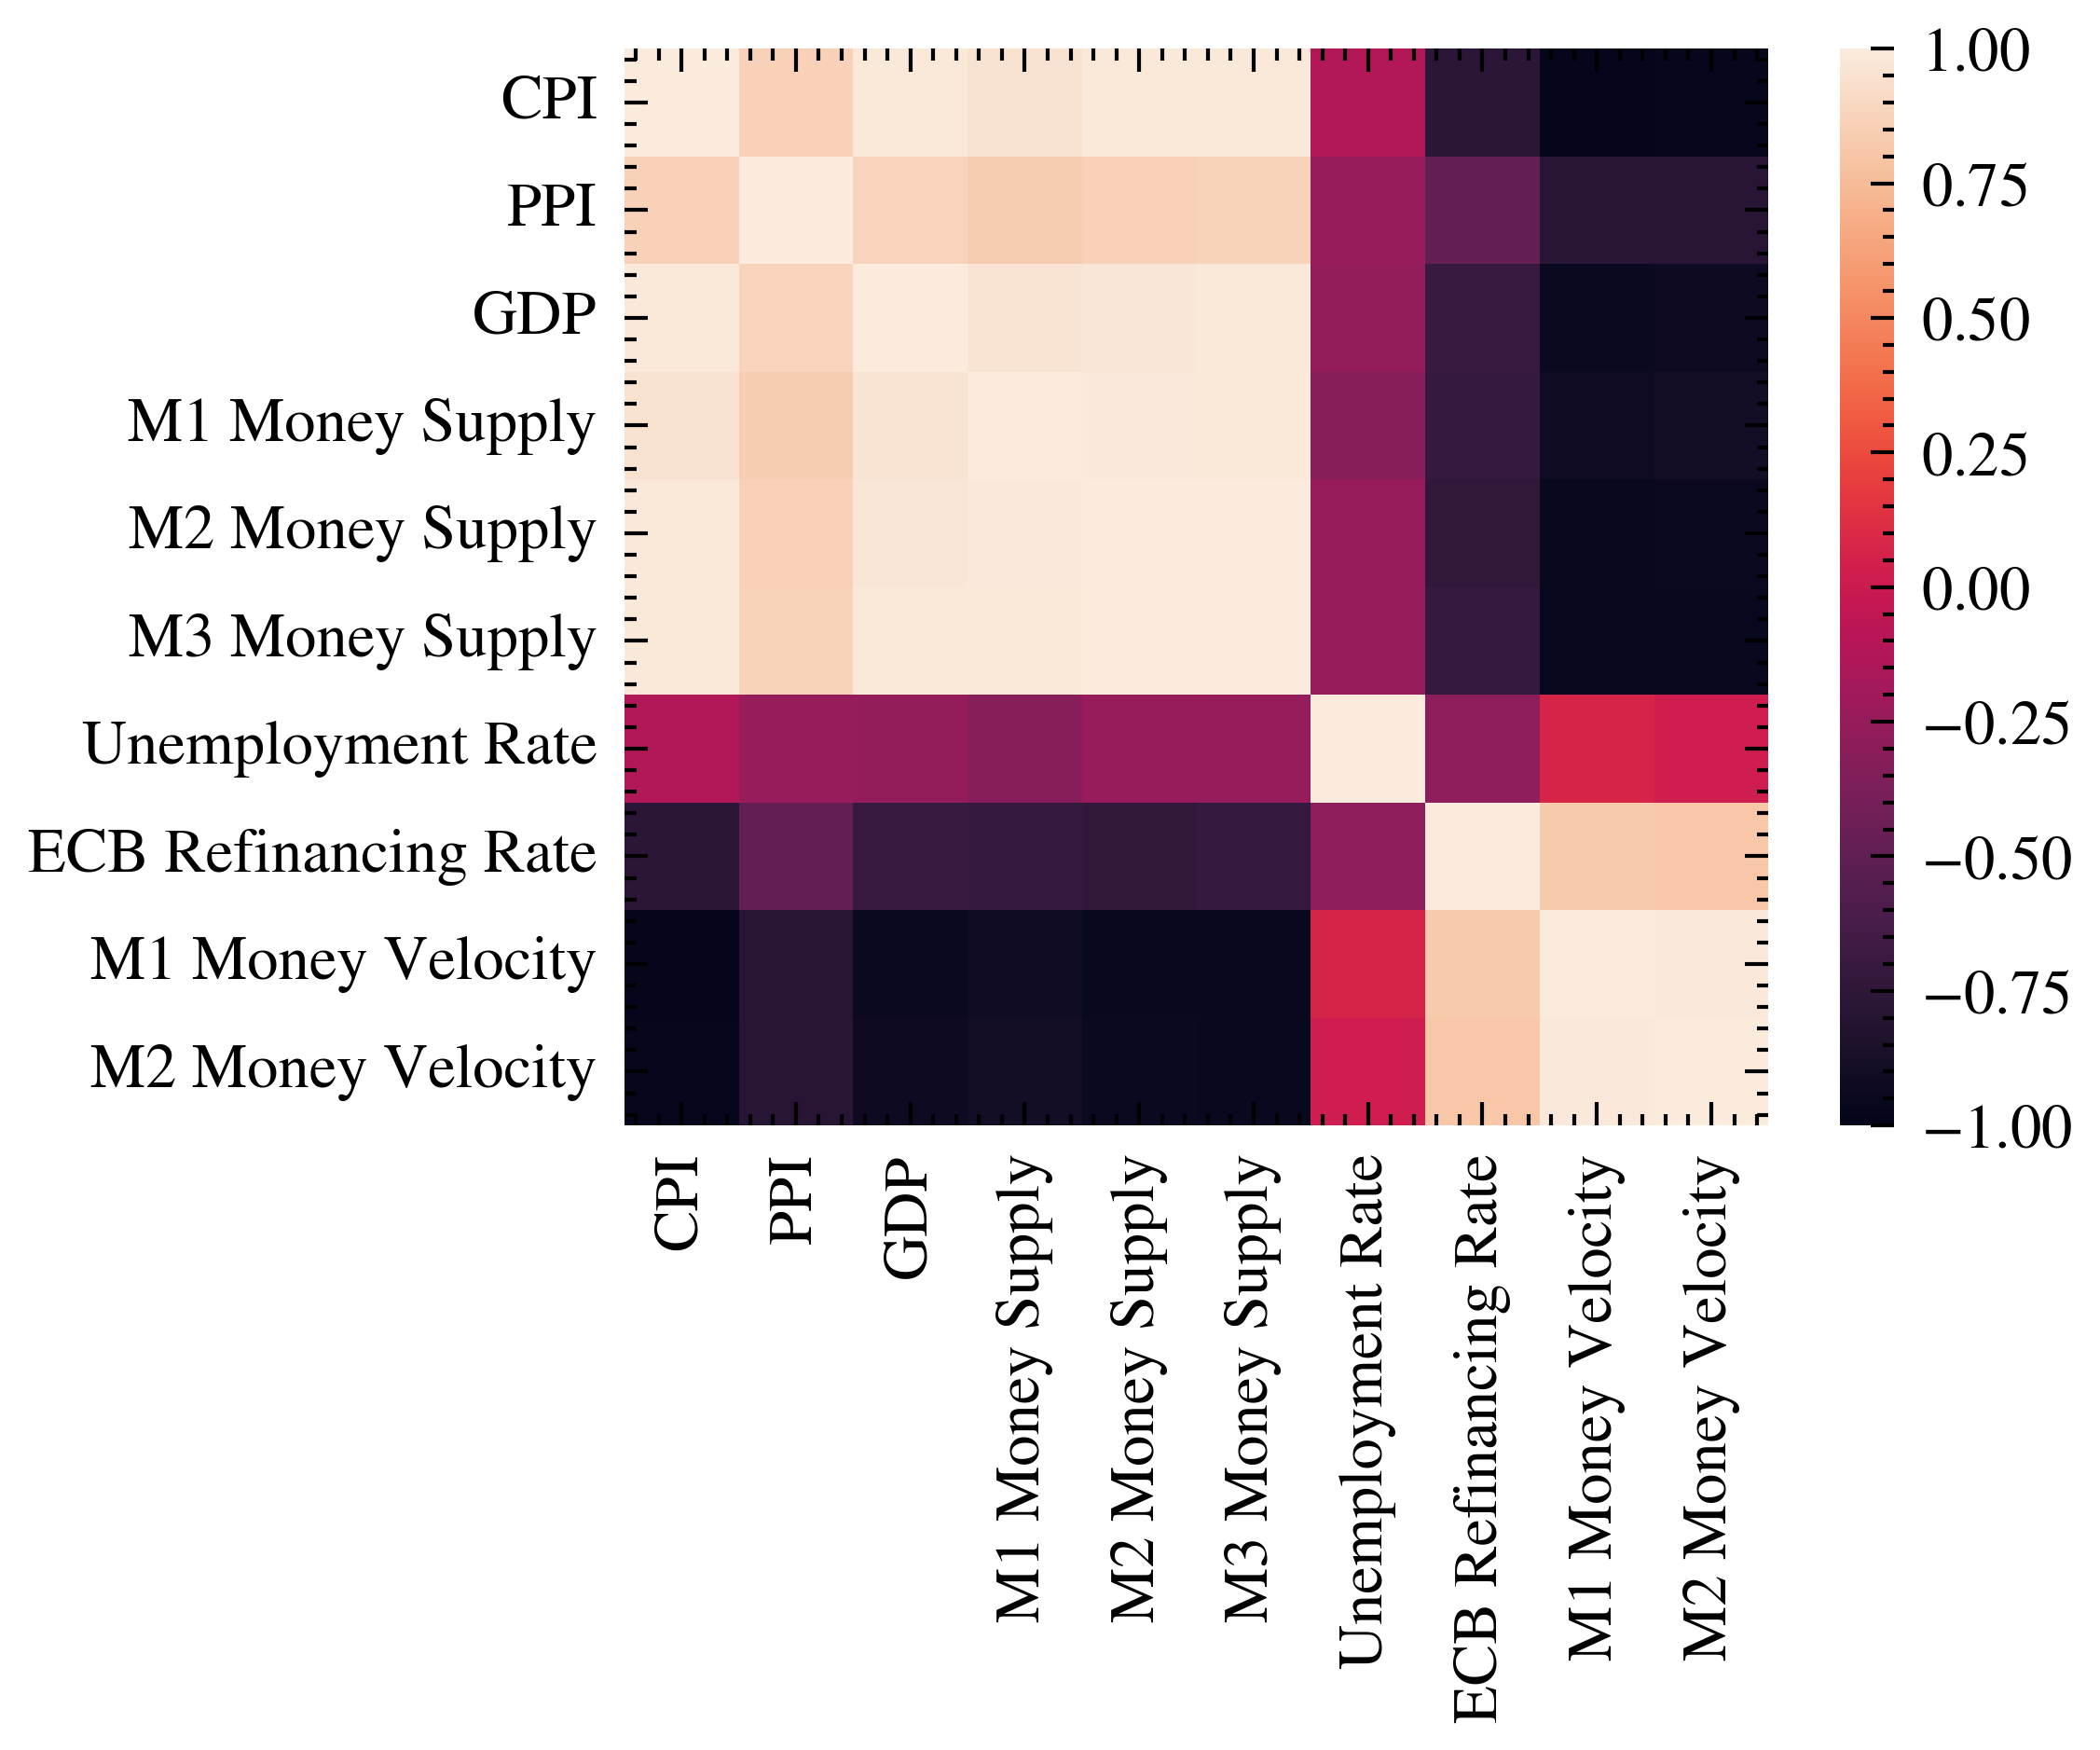

In [67]:
# correlation matrix
corr0 = np.corrcoef(X.T)
corr0 = pd.DataFrame(corr0, columns=X.columns, index=X.columns)
corr1, clstrs, silh = clusterKMeansTop(corr0=corr0, maxNumClusters=12, n_init=100)

if plotting:
    sns.heatmap(corr1, vmin=-1, vmax=1)
    # Save the plot if not already saved
    file_path = f"Research/PLOTS/correlation_matrix.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')
    plt.show

print("Cluster : Features")
for k,v in clstrs.items():
    print(k,":", v)

# Variation of Information Matrix

/workspaces/Strategy/Research/CODE/deprado.py:203: RuntimeWarning: invalid value encountered in double_scalars
  clusterTstats = {i:np.mean(silh[clstrs[i]]) / np.std(silh[clstrs[i]]) for i in clstrs.keys()}


File already exists


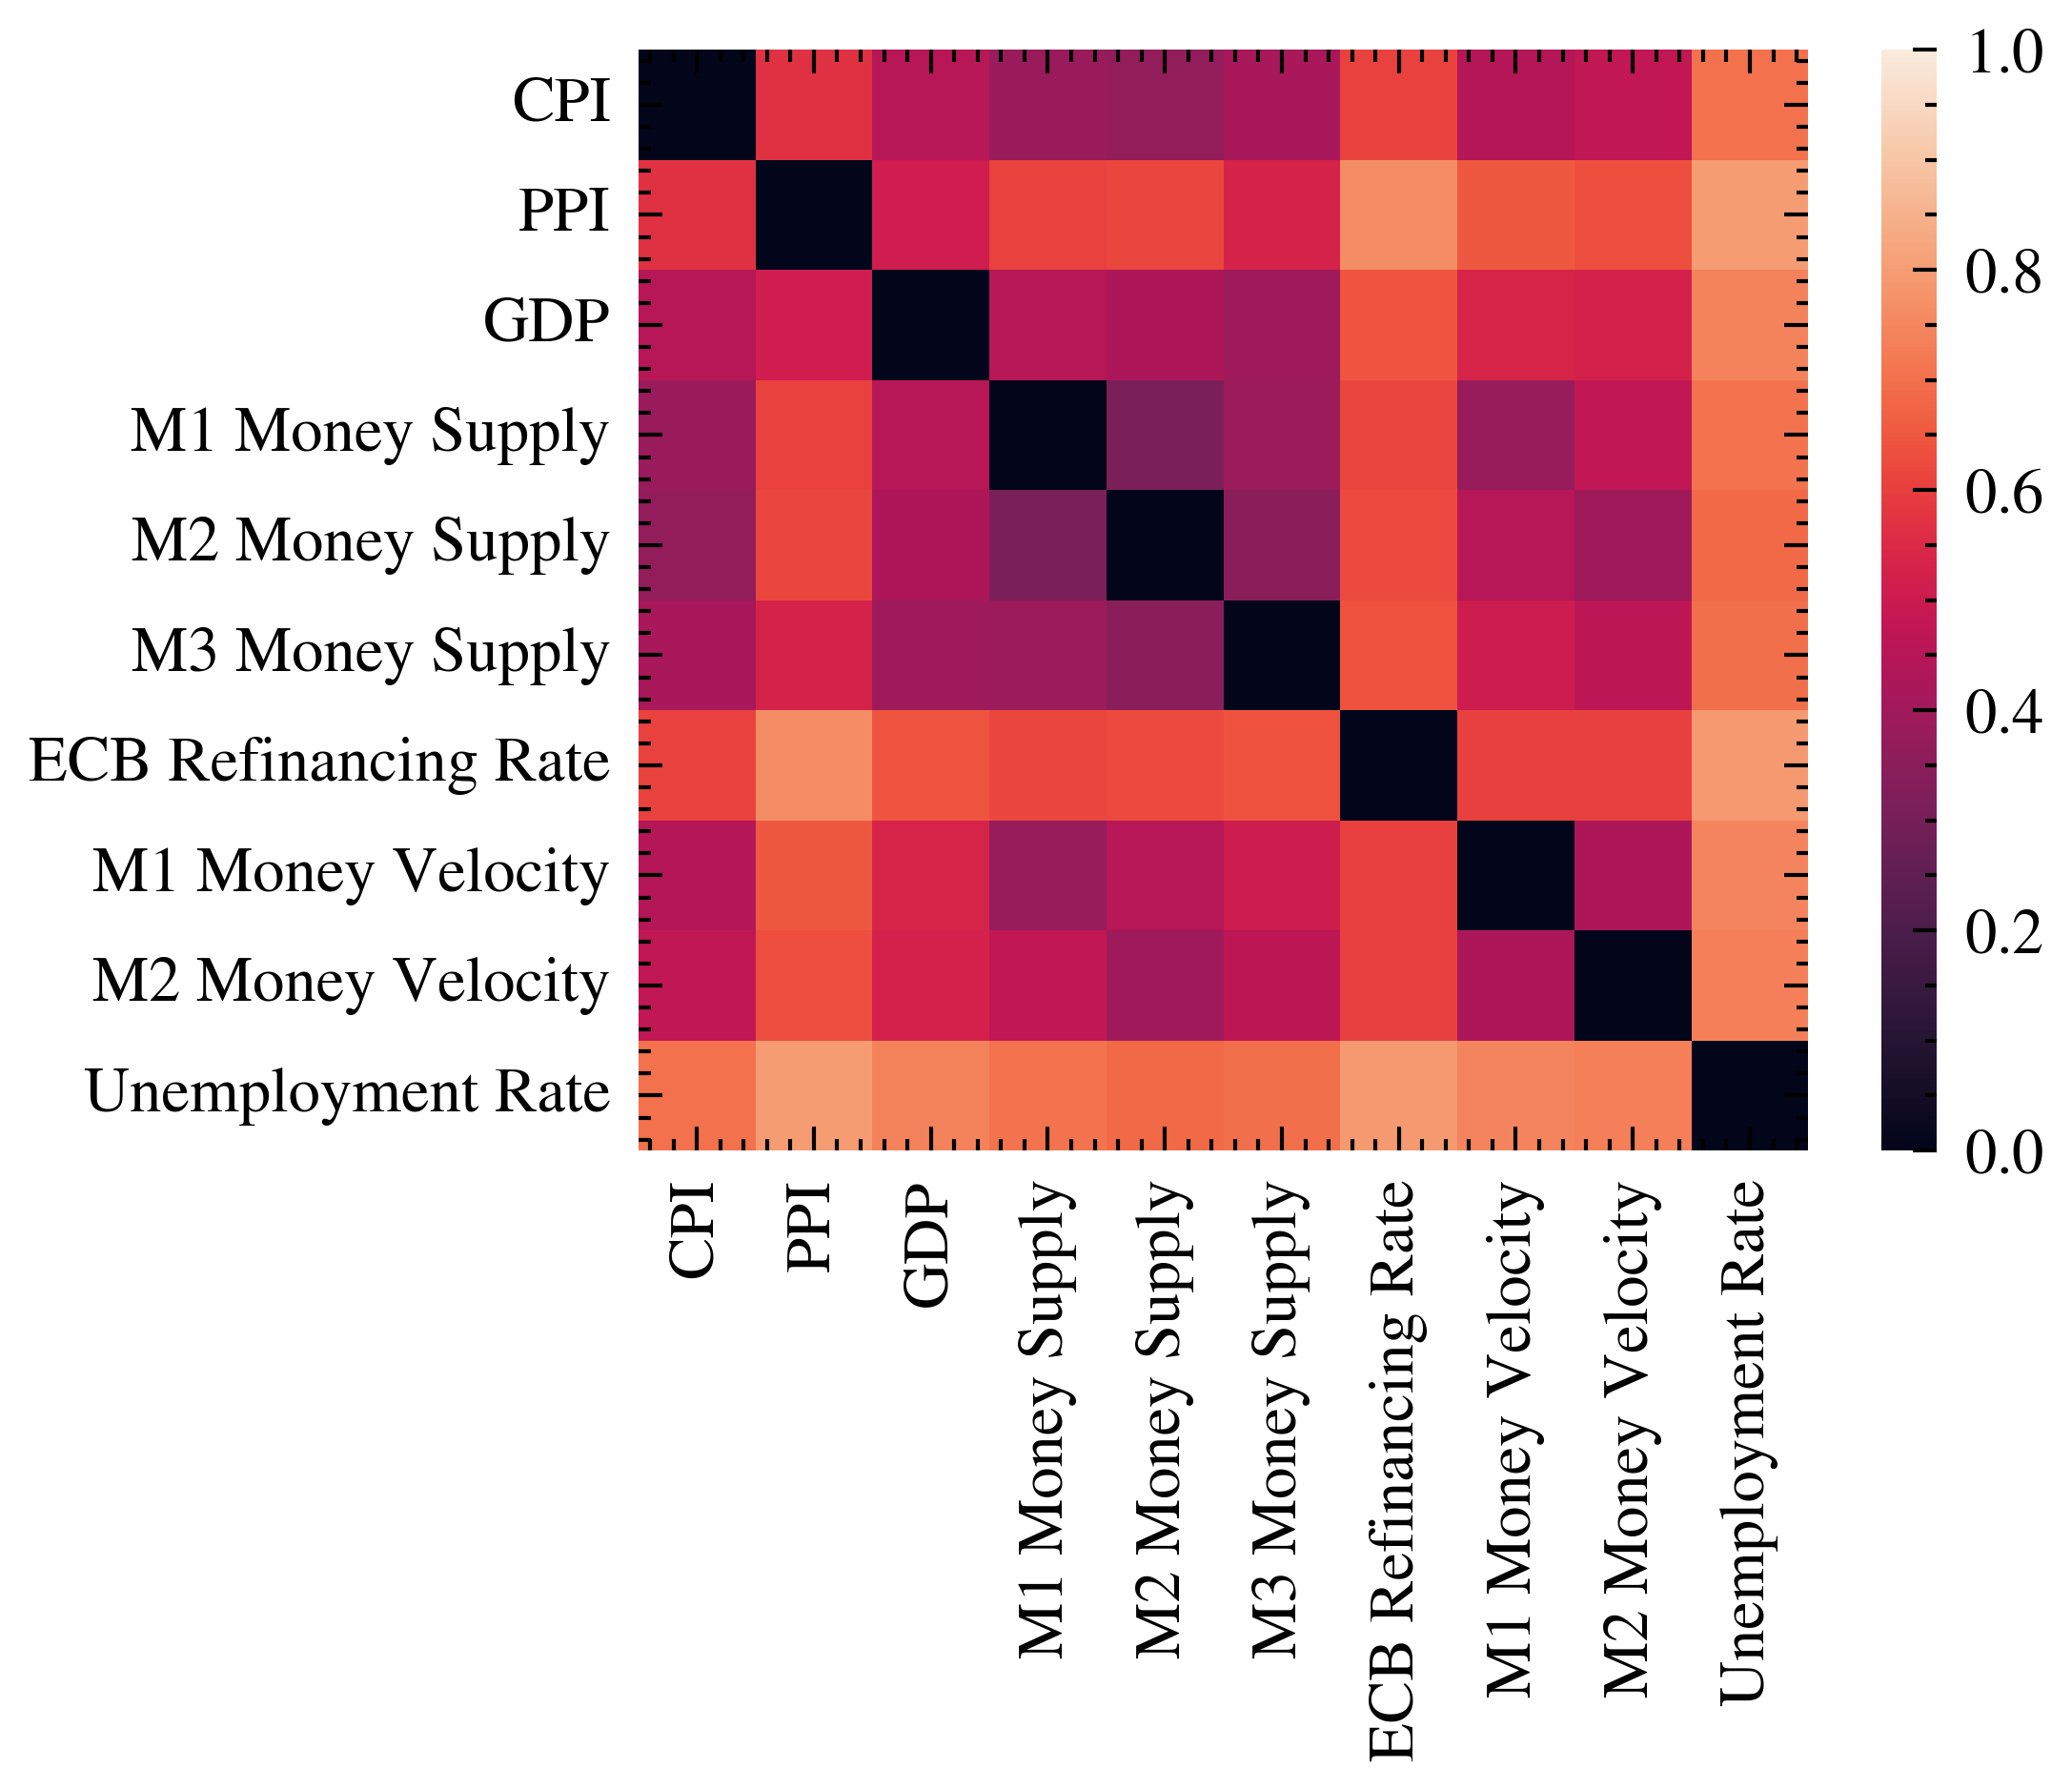

Cluster : Features
0 : ['CPI', 'PPI', 'GDP', 'M1 Money Supply', 'M2 Money Supply', 'M3 Money Supply', 'ECB Refinancing Rate', 'M1 Money Velocity', 'M2 Money Velocity']
1 : ['Unemployment Rate']


In [68]:
# variation of information matrix

corr0var = varInfoMat(X, norm=True)
corr1var, clstrsvar, silhvar = clusterKMeansTop(corr0=corr0var, maxNumClusters=12, n_init=100)

if plotting:
    sns.heatmap(corr1var, vmin=0, vmax=1)
    file_path = f"Research/PLOTS/varinfo_matrix.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')
    plt.show()

print("Cluster : Features")
for k,v in clstrsvar.items():
    print(k,":", v)

# Sample Weights

In [16]:
numCoEvents = mpPandasObj(mpNumCoEvents, ('molecule', e.index), numThreads=12, closeIdx=y.index, t1=e['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(y.index).fillna(0)
out = pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW, ('molecule',e.index), numThreads=12, t1=e['t1'], numCoEvents=numCoEvents)

2023-10-30 07:16:16.539153 100.0% mpNumCoEvents done after 0.02 minutes. Remaining 0.0 minutes..
2023-10-30 07:16:16.973590 100.0% mpSampleTW done after 0.01 minutes. Remaining 0.0 minutes..


In [17]:
# Average uniqueness used for maxSamples in Classifiers
avgU = out['tW'].mean()
avgU

0.005079833421794771

# Drop highly correlating Features

In [72]:
# drop columns
colstodrop = ['M1 Money Supply', 'M2 Money Supply', 'M3 Money Supply', 'GDP', 'M2 Money Velocity']
X.drop(colstodrop, axis=1, inplace=True)

# rawX.drop(colstodrop, axis=1, inplace=True)

File already exists


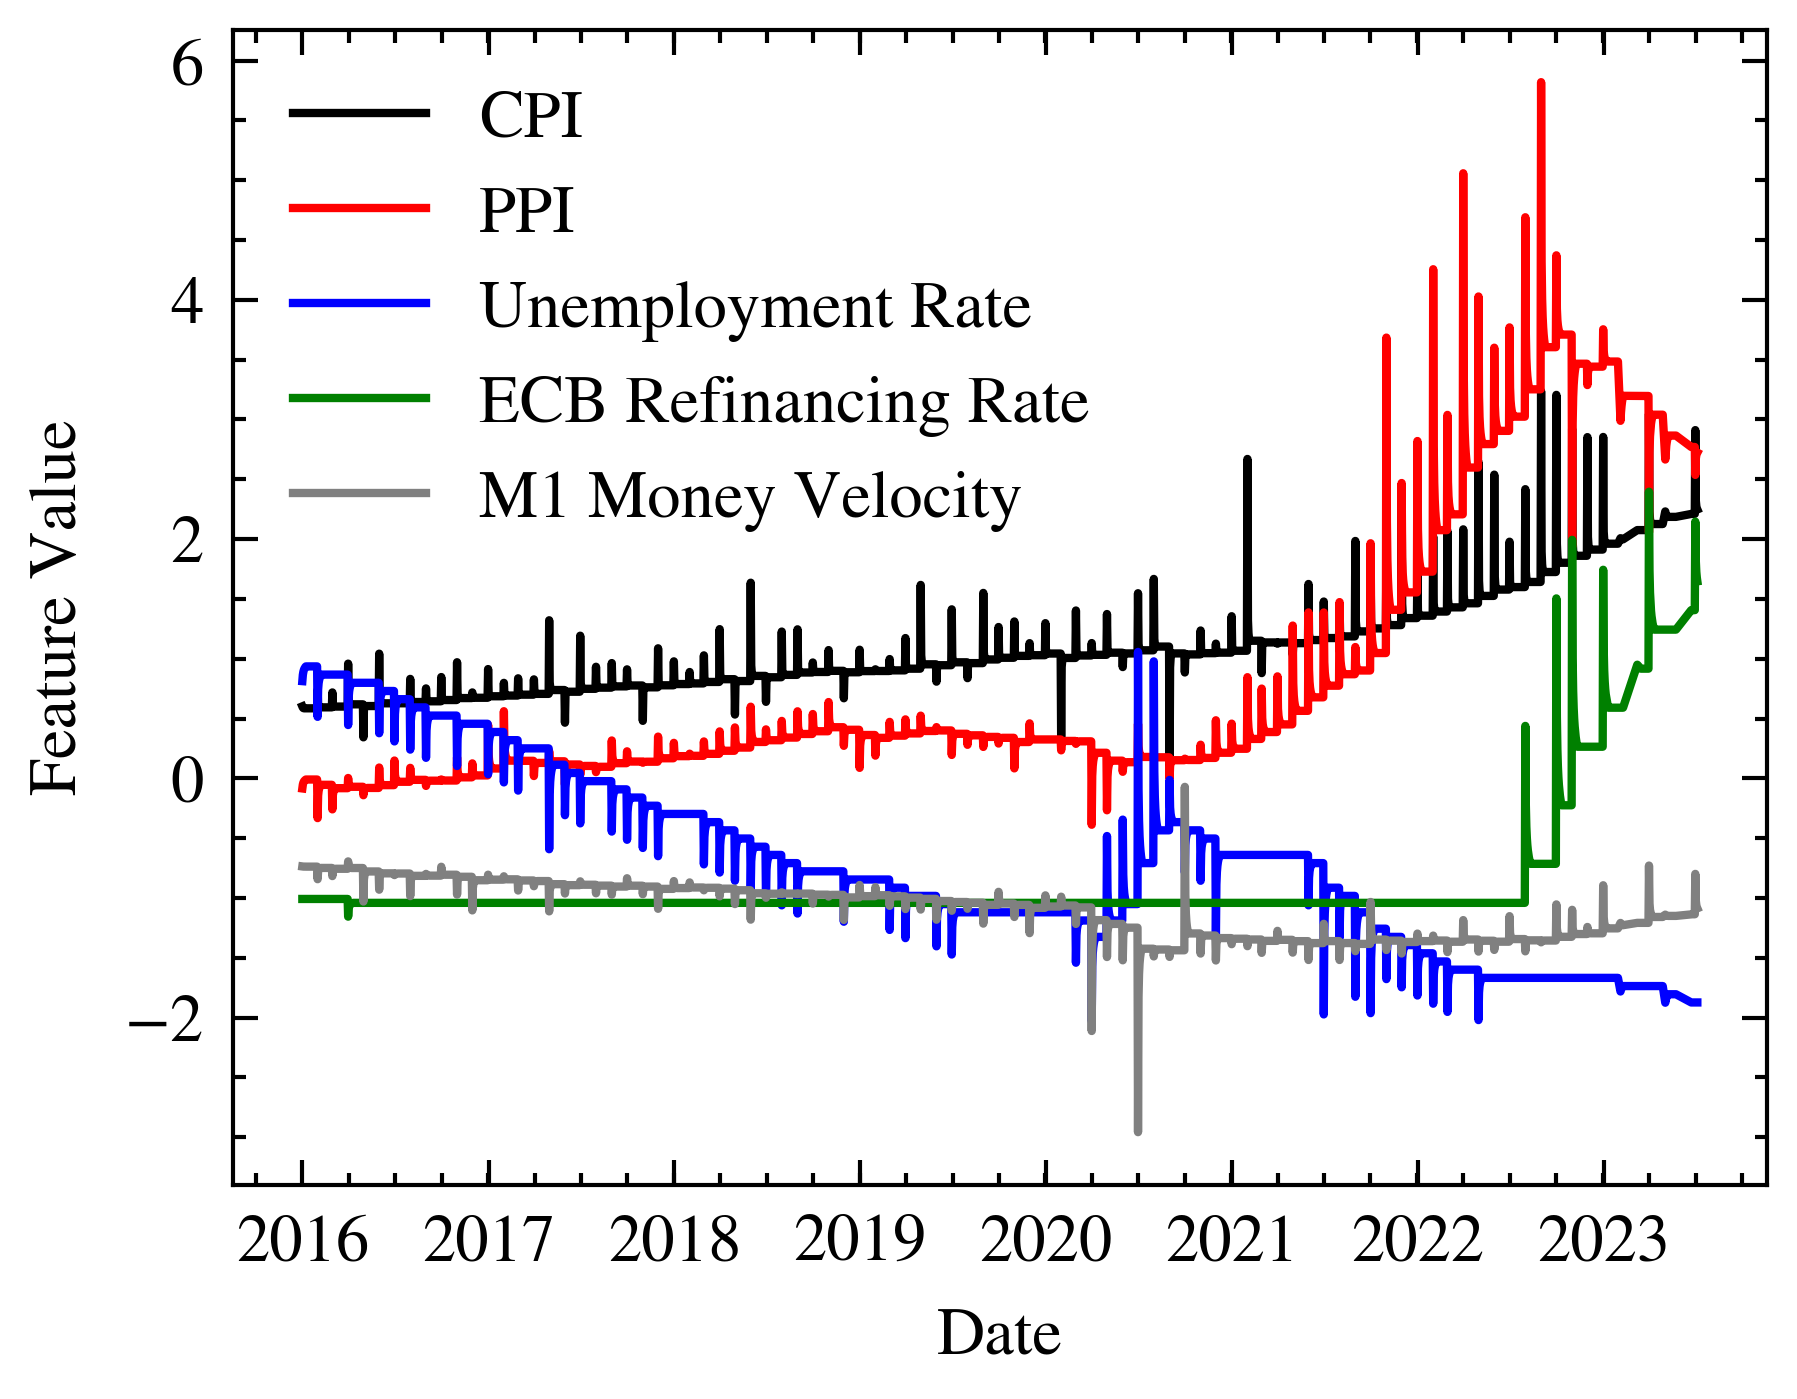

In [87]:
# Plot X with matplotlib
if plotting:
    plt.style.use(['science','ieee','no-latex'])

    cycler = plt.cycler(linestyle=['solid', 'solid', 'solid', 'solid', 'solid'],
                    color=['black', 'red', 'blue', 'green', 'grey'],
    )
    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler)

    plt.plot(X.loc['2016-01-01':])
    plt.legend(X.columns)
    plt.xlabel('Date')
    plt.ylabel('Feature Value')
    file_path = f"Research/PLOTS/features_plot.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')
    plt.show()


In [20]:
plotting = True

# Permutation Feature Importance
result = imp

In [21]:
# set up base classifier
from sklearn.tree import DecisionTreeClassiﬁer
from sklearn.ensemble import BaggingClassiﬁer

clf=DecisionTreeClassifier(criterion='entropy',max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf=BaggingClassifier(estimator=clf,n_estimators=1000,max_features=1.,max_samples=avgU,oob_score=False)

In [22]:
imp = featImpMDA(clf,X,y,10,t1)

100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


File already exists


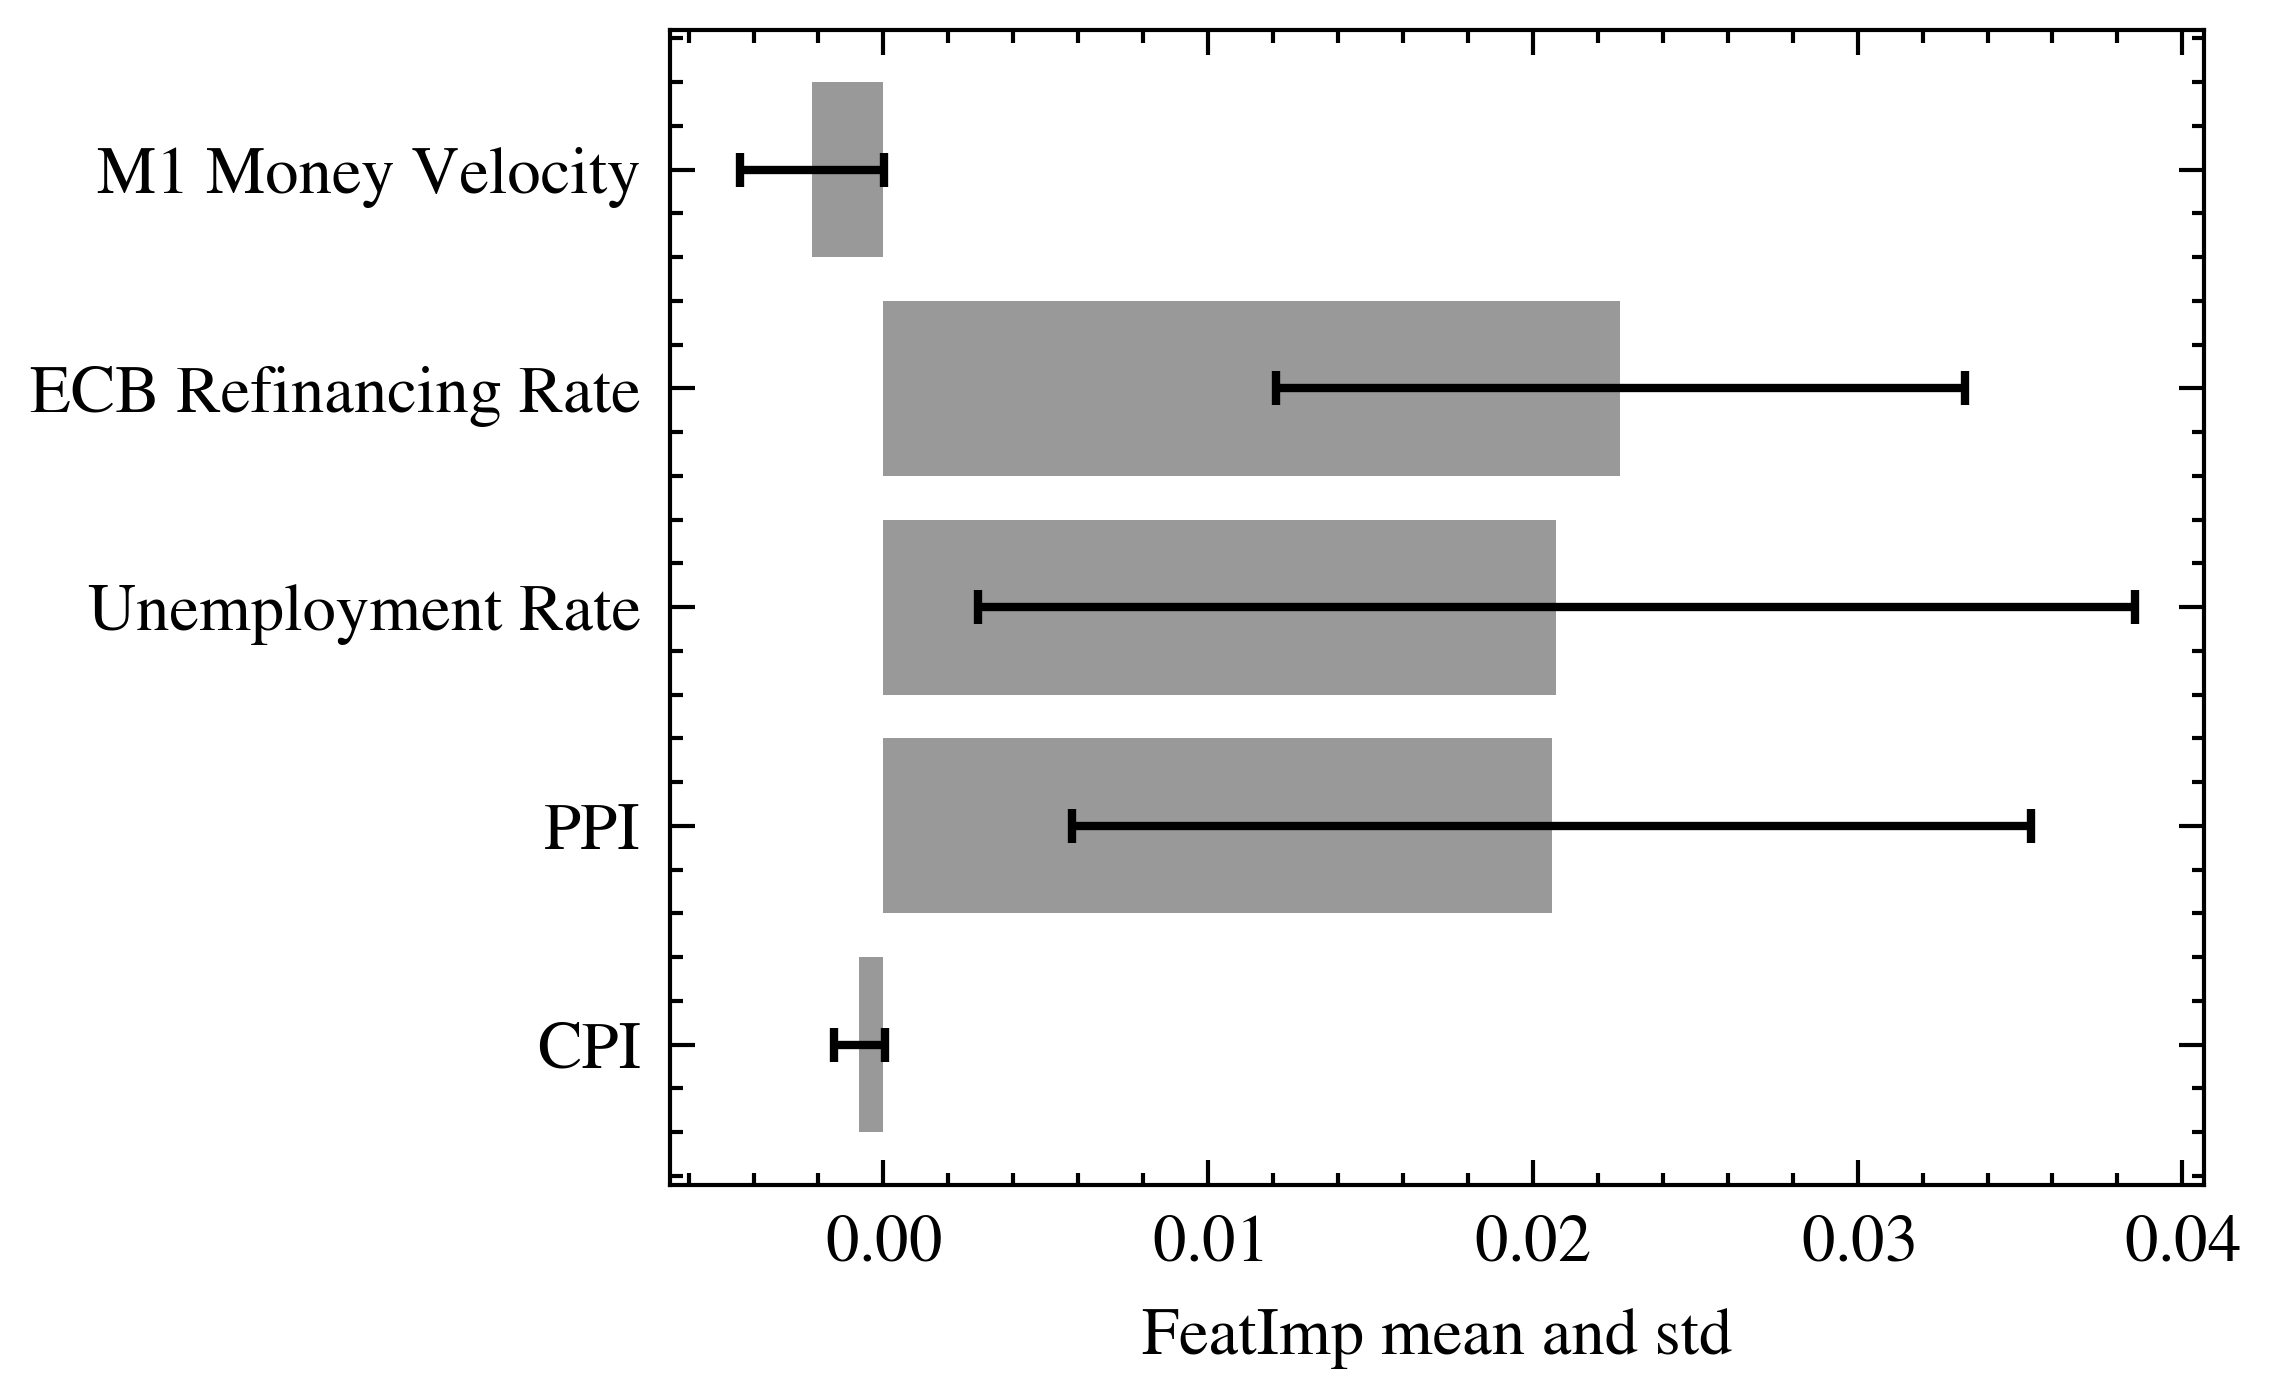

In [23]:
if plotting:
    plt.style.use(['science','ieee','no-latex'])
    plt.figure()
    y_pos = np.arange(imp.shape[0])
    plt.barh(y_pos, imp['mean'], xerr=imp['std'], alpha=0.4, capsize=2)
    plt.yticks(y_pos, imp.index)
    plt.xlabel('FeatImp mean and std')

    file_path = f"Research/PLOTS/featimp.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')

    plt.show()

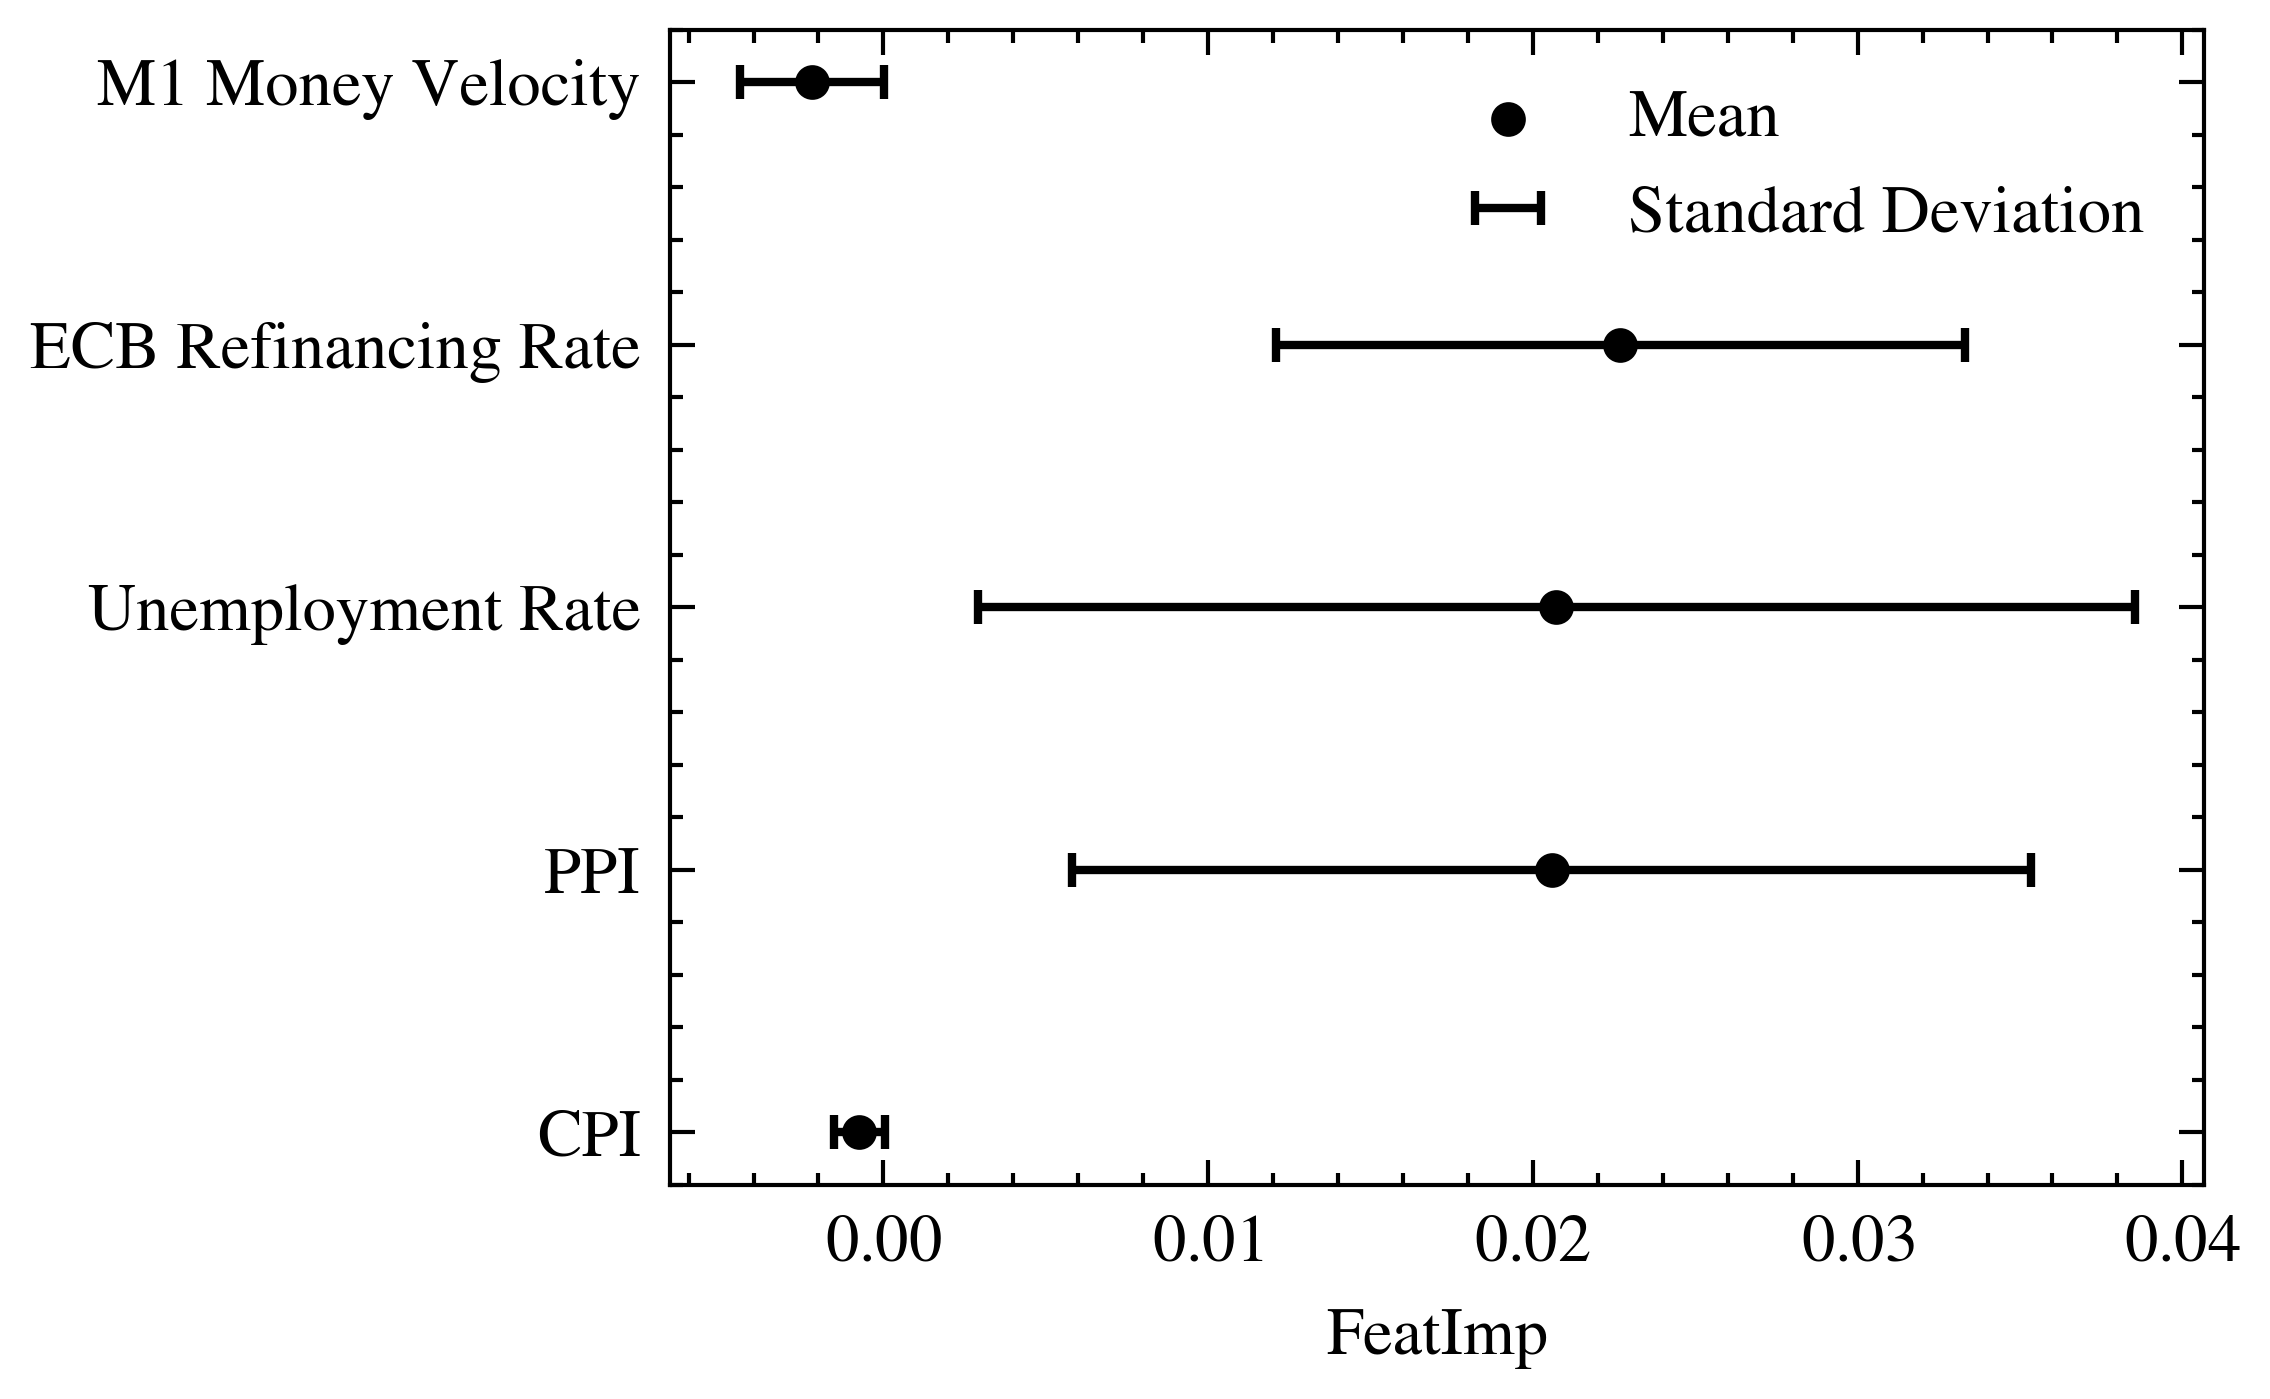

In [ ]:
plt.style.use(['science','ieee','no-latex'])
plt.figure()
y_pos = np.arange(imp.shape[0])
plt.scatter(y=y_pos, x=imp['mean'], marker='o', s=10)
plt.errorbar(x=imp['mean'], y=y_pos, xerr=imp['std'], capsize=2, fmt='none')
plt.yticks(y_pos, imp.index)
plt.xlabel('Feature Importance Value F')
plt.legend(['Mean', 'Standard Deviation'])
plt.show()

# Clustered Permutation Feature Importance

In [69]:
manual_clusters = { 0: ['CPI', 'M1 Money Velocity'],
                    1: ['ECB Refinancing Rate'],
                    2: ['Unemployment Rate'],
                    3: ['PPI'],
}

In [70]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf=BaggingClassifier(estimator=clf,n_estimators=1000,max_features=1.,max_samples=avgU,oob_score=False)
impclustered=featImpMDA_Clustered(clf, X, y, manual_clusters, 10, t1)

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


File already exists


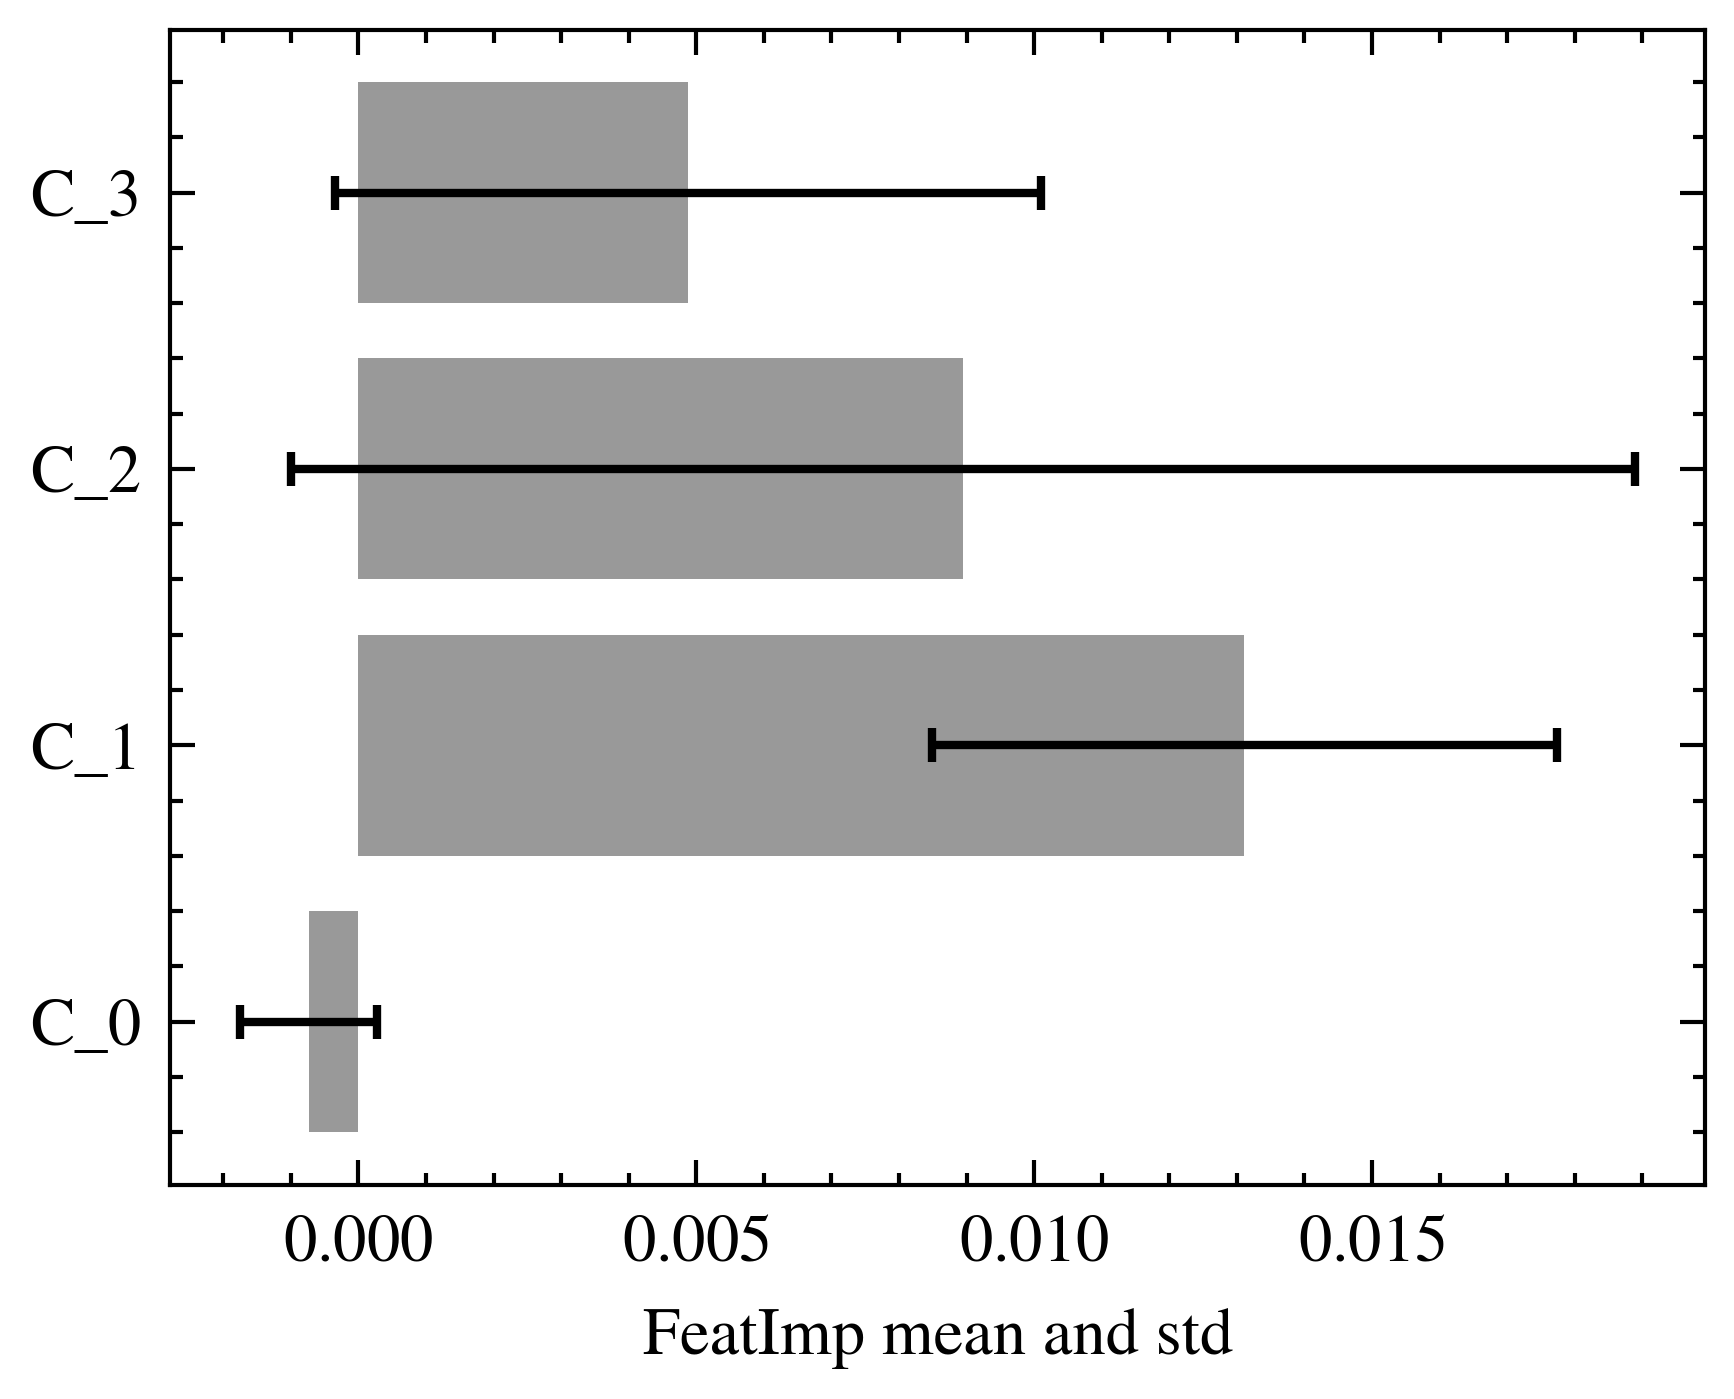

In [71]:
if plotting:
    plt.style.use(['science','ieee','no-latex'])
    plt.figure()
    y_pos = np.arange(impclustered.shape[0])
    plt.barh(y_pos, impclustered['mean'], xerr=impclustered['std'], alpha=0.4, capsize=2)
    plt.yticks(y_pos, impclustered.index)
    plt.xlabel('FeatImp mean and std')

    file_path = f"Research/PLOTS/featimp_clustered.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')

    plt.show()

# Performance of Base Classifier

In [94]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

n_splits = 10
cvGen = PurgedKFold(n_splits=n_splits,t1=t1) # purged
scr0, scr1 = pd.Series(dtype=np.float64), pd.DataFrame(columns=clstrs.keys())  # make empty scrorer
cm = []
for i,(train,test) in tqdm(enumerate(cvGen.split(X=X, y=y)), total=n_splits):
    # train and test by cv folds
    X0, y0 = X.iloc[train,:], y.iloc[train]
    X1, y1 = X.iloc[test,:], y.iloc[test]
    # fit classifier and compute score
    fit = clf.fit(X=X0,y=y0)
    prob = fit.predict_proba(X1)
    
    # compute accuracy
    scr0.loc[i] = accuracy_score(y1, fit.predict(X1))

    # compute confusion matrix
    cm.append(confusion_matrix(y1, fit.predict(X1)))

    # compute log loss
    # scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


In [95]:
cm_mean = np.mean(cm, axis=0).astype(int)

tp = cm_mean[1, 1]  # True Positives
tn = cm_mean[0, 0]  # True Negatives
total = tp + tn + cm_mean[0, 1] + cm_mean[1, 0]  # Total observations

acc = (tp + tn) / total  # Accuracy
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6224


File already exists


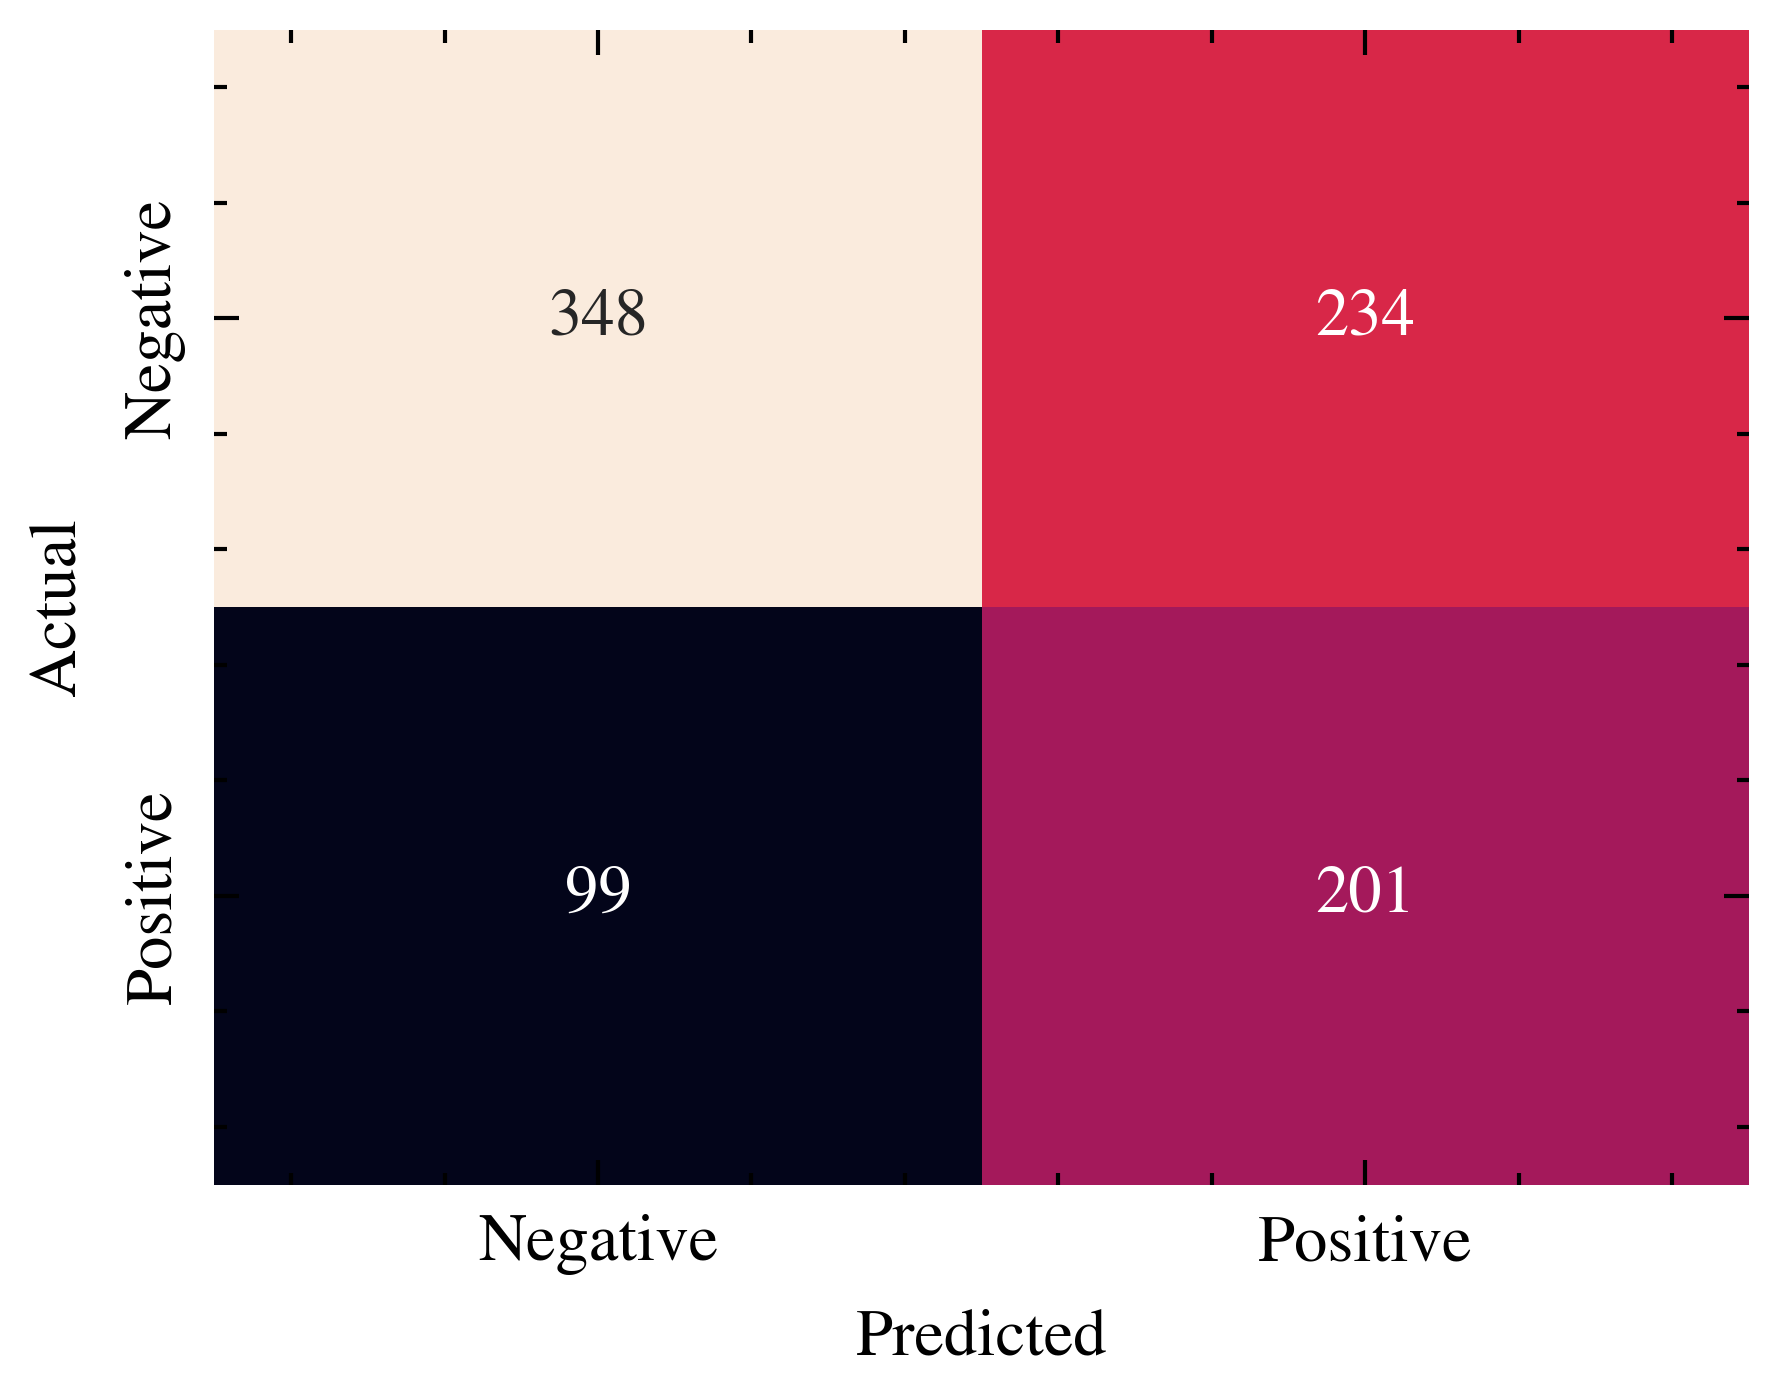

In [96]:
if plotting:
    sns.heatmap(cm_mean, annot=True, 
                fmt="d",
                cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    file_path = f"Research/PLOTS/confusion_matrix.png"
    if not os.path.exists(file_path):
        plt.savefig(file_path, format='png', dpi=300)
        print('File saved')
    else:
        print('File already exists')

    plt.show()
